In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
import tensorflow as tf
import matplotlib.pyplot as plt

In [14]:
# Function to create sequences for LSTM model
def create_sequences(data, target, time_steps=1):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data.iloc[i:(i + time_steps)].values)
        ys.append(target.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [15]:
# Suppress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [16]:
# Load the CSV files
df1 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/01.csv', delimiter=';')
df2 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/02.csv', delimiter=';')
df3 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/03.csv', delimiter=';')

In [17]:
# Add VM identifier to each dataframe
df1['VM'] = 'VM1'
df2['VM'] = 'VM2'
df3['VM'] = 'VM3'

In [18]:
# Combine the dataframes
combined_df = pd.concat([df1, df2, df3])

# Replace commas with dots and convert to numeric
combined_df['CPU usage [%]'] = combined_df['CPU usage [%]'].str.replace(',', '.').astype(float)

In [19]:
# Normalize the Data
cpu_mhz_scaler = MinMaxScaler()
cpu_percent_scaler = MinMaxScaler()

In [20]:
combined_df['CPU usage [MHZ]'] = cpu_mhz_scaler.fit_transform(combined_df[['CPU usage [MHZ]']])
combined_df['CPU usage [%]'] = cpu_percent_scaler.fit_transform(combined_df[['CPU usage [%]']])

# Define features and target
features = ['CPU usage [MHZ]', 'CPU usage [%]']
target = 'CPU usage [MHZ]'

In [21]:
# Create sequences
time_steps = 10
X, y = create_sequences(combined_df[features], combined_df[target], time_steps)

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [23]:
# Build the LSTM Model with a CNN layer
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
# Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=1, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
18784/18784 [==============================] - 86s 4ms/step - loss: 0.0025 - val_loss: 3.5576e-04
Epoch 2/10
18784/18784 [==============================] - 88s 5ms/step - loss: 0.0016 - val_loss: 6.5382e-04
Epoch 3/10
18784/18784 [==============================] - 90s 5ms/step - loss: 0.0013 - val_loss: 2.7223e-04
Epoch 4/10
18784/18784 [==============================] - 88s 5ms/step - loss: 0.0011 - val_loss: 3.0541e-04
Epoch 5/10
18784/18784 [==============================] - 83s 4ms/step - loss: 0.0010 - val_loss: 4.6877e-04
Epoch 6/10
18784/18784 [==============================] - 80s 4ms/step - loss: 0.0010 - val_loss: 5.9786e-04
Epoch 7/10
18784/18784 [==============================] - 86s 5ms/step - loss: 9.9261e-04 - val_loss: 3.8366e-04
Epoch 8/10
18784/18784 [==============================] - 82s 4ms/step - loss: 9.0131e-04 - val_loss: 3.0895e-04
Epoch 9/10
18784/18784 [==============================] - 84s 4ms/step - loss: 8.5144e-04 - val_loss: 3.2412e-04
Epoch 1

In [25]:
# Evaluate the Model
predictions = model.predict(X_test)

# Rescale predictions back to original scale using the correct scaler
y_test_scaled = cpu_mhz_scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_scaled = cpu_mhz_scaler.inverse_transform(predictions)

# Plot Training and Validation Loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

196/196 [==============================] - 2s 3ms/step


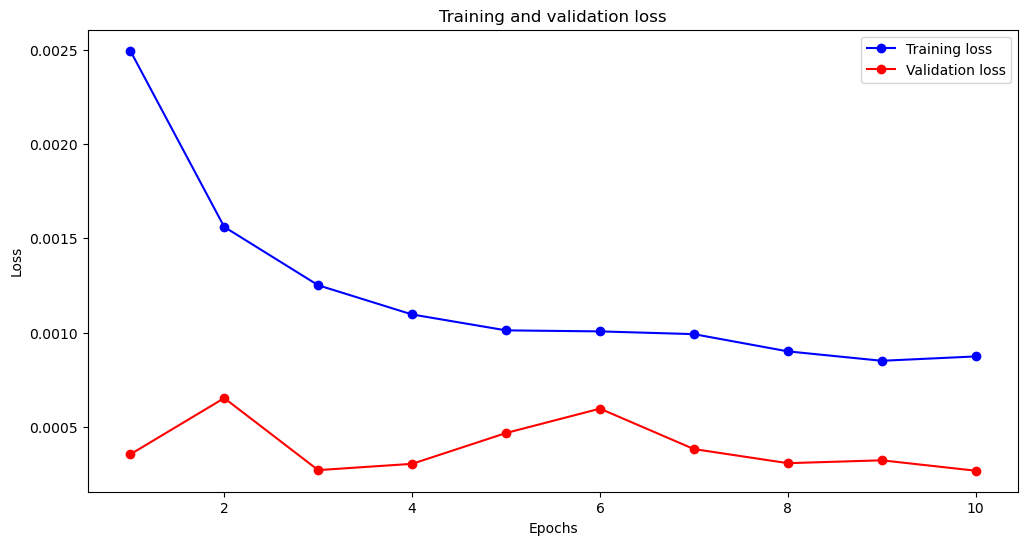

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Real CPU Usage [MHZ]': y_test_scaled.flatten(),
    'Predicted CPU Usage [MHZ]': predictions_scaled.flatten()
})

# Display the first few rows of the DataFrame
print(comparison_df.head())

   Real CPU Usage [MHZ]  Predicted CPU Usage [MHZ]
0                 112.0                 126.042213
1                 112.0                 125.615135
2                 133.0                 139.180923
3                 178.0                 189.832275
4                 113.0                 125.964272


   Real CPU Usage [MHZ]  Predicted CPU Usage [MHZ]
0                 112.0                 126.042213
1                 112.0                 125.615135
2                 133.0                 139.180923
3                 178.0                 189.832275
4                 113.0                 125.964272


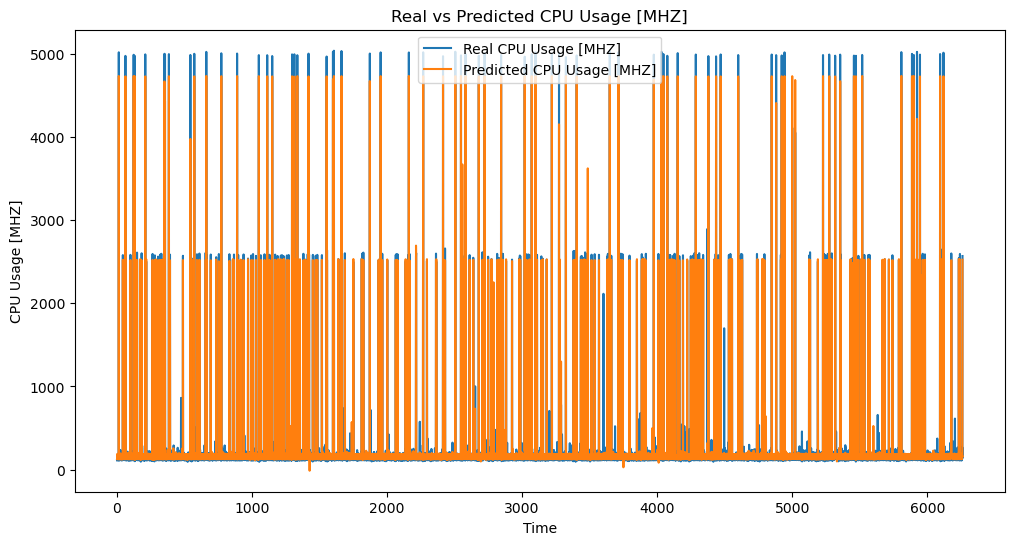

Mean Absolute Percentage Error (MAPE): 11.59%
Precision: 88.41%


In [28]:
# Ensure lengths match before creating DataFrame
if len(y_test_scaled) == len(predictions_scaled):
    # Create a DataFrame for comparison
    comparison_df = pd.DataFrame({
        'Real CPU Usage [MHZ]': y_test_scaled.flatten(),
        'Predicted CPU Usage [MHZ]': predictions_scaled.flatten()
    })

    # Display the first few rows of the DataFrame
    print(comparison_df.head())

    # Save the DataFrame to a CSV file for further inspection if needed
    comparison_df.to_csv('comparison.csv', index=False)

    # Plot Real vs Predicted Values
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df['Real CPU Usage [MHZ]'], label='Real CPU Usage [MHZ]')
    plt.plot(comparison_df['Predicted CPU Usage [MHZ]'], label='Predicted CPU Usage [MHZ]')
    plt.title('Real vs Predicted CPU Usage [MHZ]')
    plt.xlabel('Time')
    plt.ylabel('CPU Usage [MHZ]')
    plt.legend()
    plt.show()

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test_scaled.flatten() - predictions_scaled.flatten()) / y_test_scaled.flatten())) * 100

    # Calculate precision as 100 - MAPE
    precision = 100 - mape

    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    print(f'Precision: {precision:.2f}%')
else:
    print("Error: Lengths of y_test_scaled and predictions_scaled do not match.")